In [2]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')
sys.path.append(gh_dir+'linmix/')
import asurv
import linmix

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
#bat_c12.loc['UGC06728', 'lir_sf'] += 2.0
#bat_c12.loc['UGC06728', 'mdust'] += 2.0
#bat_c12.loc['2MASXiJ1802473-145454', 'lir_sf'] += 2.0
#bat_c12.loc['2MASXiJ1802473-145454', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_c12['Redshift'] = bat_info['Redshift']

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_c12['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))


# Calculate the SFR
bat_c12['sfr'] = bat_c12['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)
bat_c12['sfr_68_up'] = np.sqrt(bat_c12['lir_sf_err_high']**2 + 0.2**2)
bat_c12['sfr_68_down'] = np.sqrt(bat_c12['lir_sf_err_low']**2 + 0.2**2)
bat_c12['sfr_err'] = np.max(np.vstack([bat_c12['sfr_68_up'], bat_c12['sfr_68_down']]), axis=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['bat_flux_err_low'] = bat_flux['BAT_flux'] - bat_flux['BAT_flux_90_low']
bat_flux['bat_flux_err_high'] = bat_flux['BAT_flux_90_high'] - bat_flux['BAT_flux']
bat_flux['lbat'] = np.log10(4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12))
bat_flux['bat_err'] = np.max(np.vstack([bat_flux['bat_flux_err_low'], bat_flux['bat_flux_err_high']]), axis=0)
bat_flux['lbat_err'] = 0.434*4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['bat_err']*10**(-12)/(10**bat_flux['lbat'])
bat_flux['lbat_flag'] = pd.Series(index=bat_flux.index)
bat_flux.loc[bat_flux['BAT_flux_90_high'] == 0, 'lbat_flag'] = 0
bat_flux.loc[bat_flux['BAT_flux_90_low'] != 0, 'lbat_flag'] = 1
bat_flux.loc[bat_flux['lbat_flag'] == 0, 'lbat_err'] = 0

bat_c12['lbat'] = bat_flux['lbat']
bat_c12['lbat_err'] = bat_flux['lbat_err']
bat_c12['lbat_flag'] = bat_flux['lbat_flag']

In [5]:
broad_type = pd.Series(index=bat_info.index, name='Sy_Type')

for n in bat_info.index.values:

    type_split = bat_info.loc[n, 'Seyfert_Type'].split()

    if ((type_split[0] == 'Sy')):
        if ((type_split[1] == '1') | (type_split[1] == '1.2') | (type_split[1] == '1.4') | (type_split[1] == '1.5')):

            broad_type.loc[n] = 'Sy 1'
            
        elif ((type_split[1] == '2') | (type_split[1] == '1.8') | (type_split[1] == '1.9')):
            
            broad_type.loc[n] = 'Sy 2'
    else:

        if (type_split[0] == 'LINER'):
            
            broad_type.loc[n] = 'LINER'

        elif (type_split[0] == 'AGN'):
            
            broad_type.loc[n] = 'AGN'

In [6]:
bat_c12['Sy_Type'] = broad_type
bat_sy1 = bat_c12[bat_c12['Sy_Type'] == 'Sy 1']
bat_sy2 = bat_c12[bat_c12['Sy_Type'] == 'Sy 2']

In [7]:
x = bat_c12['lbat'].values
y = bat_c12['sfr'].values
xerr = bat_c12['lbat_err'].values
yerr = bat_c12['sfr_err'].values
yerr[np.isnan(yerr)] = 1.
delta = bat_c12['lir_sf_flag'].values
delta[delta == 1] = 0
delta = delta + 1

#lm = linmix.LinMix(x=x, y=y, xsig=xerr, ysig=yerr, delta=delta)
#lm.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm.chain['beta']), ' +/- ', np.std(lm.chain['beta'])
print 'Intercept = ', np.median(lm.chain['alpha']), ' +/- ', np.std(lm.chain['alpha'])
print 'Sigsqr = ', np.median(lm.chain['sigsqr']), ' +/- ', np.std(lm.chain['sigsqr'])
print 'R^2 = ', np.median(lm.chain['corr']), ' +/- ', np.std(lm.chain['corr'])

Total Sample:
Slope = 

NameError: name 'lm' is not defined

In [98]:
x_sy1 = bat_sy1['lbat'].values
y_sy1 = bat_sy1['sfr'].values
xerr_sy1 = bat_sy1['lbat_err'].values
yerr_sy1 = bat_sy1['sfr_err'].values
yerr_sy1[np.isnan(yerr_sy1)] = 1.
delta_sy1 = bat_sy1['lir_sf_flag'].values
delta_sy1[delta_sy1 == 1] = 0
delta_sy1 = delta_sy1 + 1

lm_sy1 = linmix.LinMix(x=x_sy1, y=y_sy1, xsig=xerr_sy1, ysig=yerr_sy1, delta=delta_sy1)
lm_sy1.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm_sy1.chain['beta']), ' +/- ', np.std(lm_sy1.chain['beta'])
print 'Intercept = ', np.median(lm_sy1.chain['alpha']), ' +/- ', np.std(lm_sy1.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy1.chain['sigsqr']), ' +/- ', np.std(lm_sy1.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy1.chain['corr']), ' +/- ', np.std(lm_sy1.chain['corr'])

Total Sample:
Slope =  0.318130608374  +/-  0.0907116923967
Intercept =  -13.6501293836  +/-  3.94950311845
Sigsqr =  0.199507643645  +/-  0.0385254878257
R^2 =  0.352689950016  +/-  0.101340258588


In [89]:
x_sy2 = bat_sy2['lbat'].values
y_sy2 = bat_sy2['sfr'].values
xerr_sy2 = bat_sy2['lbat_err'].values
yerr_sy2 = bat_sy2['sfr_err'].values
yerr_sy2[np.isnan(yerr_sy2)] = 1.
delta_sy2 = bat_sy2['lir_sf_flag'].values
delta_sy2[delta_sy2 == 1] = 0
delta_sy2 = delta_sy2 + 1

lm_sy2 = linmix.LinMix(x=x_sy2, y=y_sy2, xsig=xerr_sy2, ysig=yerr_sy2, delta=delta_sy2)
lm_sy2.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm_sy2.chain['beta']), ' +/- ', np.std(lm_sy2.chain['beta'])
print 'Intercept = ', np.median(lm_sy2.chain['alpha']), ' +/- ', np.std(lm_sy2.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy2.chain['sigsqr']), ' +/- ', np.std(lm_sy2.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy2.chain['corr']), ' +/- ', np.std(lm_sy2.chain['corr'])

Total Sample:
Slope =  0.253945899399  +/-  0.0716191532247
Intercept =  -10.6884635319  +/-  3.09802361671
Sigsqr =  0.250828509318  +/-  0.0316246799251
R^2 =  0.280539299637  +/-  0.0804539953884


In [14]:
xfit = np.arange(41.0, 45.0, 0.001)
yfit_all = np.zeros((len(lm.chain['beta']), len(xfit)))
#yfit_sy1 = np.zeros((len(lm_sy1.chain['beta']), len(xfit)))
#yfit_sy2 = np.zeros((len(lm_sy2.chain['beta']), len(xfit)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_all[i, :] = alpha_i + beta_i*xfit

    #beta_sy1_i = lm_sy1.chain['beta'][i]
    #alpha_sy1_i = lm_sy1.chain['alpha'][i]
    #yfit_sy1[i, :] = alpha_sy1_i + beta_sy1_i*xfit
    
    #beta_sy2_i = lm_sy2.chain['beta'][i]
    #alpha_sy2_i = lm_sy2.chain['alpha'][i]
    #yfit_sy2[i, :] = alpha_sy2_i + beta_sy2_i*xfit


yfit_median = np.median(yfit_all, axis=0)
yfit_upper95 = np.percentile(yfit_all, axis=0, q=97.5)
yfit_lower95 = np.percentile(yfit_all, axis=0, q=2.5)

#yfit_sy1_median = np.median(yfit_sy1, axis=0)
#yfit_sy1_upper95 = np.percentile(yfit_sy1, axis=0, q=97.5)
#yfit_sy1_lower95 = np.percentile(yfit_sy1, axis=0, q=2.5)

#yfit_sy2_median = np.median(yfit_sy2, axis=0)
#yfit_sy2_upper95 = np.percentile(yfit_sy2, axis=0, q=97.5)
#yfit_sy2_lower95 = np.percentile(yfit_sy2, axis=0, q=2.5)

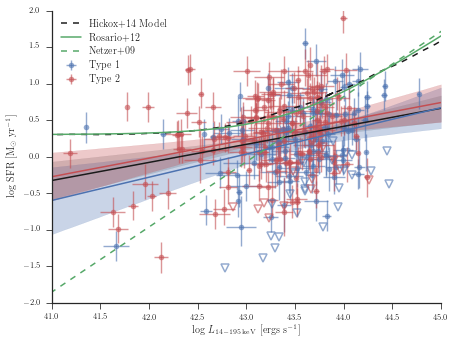

In [92]:
fig = plt.figure(figsize=(textwidth, 3./4.*textwidth))
plt.errorbar(x_sy1[delta_sy1==1], y_sy1[delta_sy1==1], xerr=xerr_sy1[delta_sy1==1], yerr=bat_sy1.loc[delta_sy1==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
             fmt='o', color='b', ls='None', alpha=0.6, label='Type 1')
plt.errorbar(x_sy2[delta_sy2==1], y_sy2[delta_sy2==1], xerr=xerr_sy2[delta_sy2==1], yerr=bat_sy2.loc[delta_sy2==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
             fmt='o', color='r', ls='None', alpha=0.6, label='Type 2')
plt.plot(x_sy1[delta_sy1==0], y_sy1[delta_sy1==0], marker='v', markeredgecolor='b', markerfacecolor='None',
         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)
plt.plot(x_sy2[delta_sy2==0], y_sy2[delta_sy2==0], marker='v', markeredgecolor='r', markerfacecolor='None',
         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)
plt.plot(xfit, yfit_median, 'k-', lw=1.5)
plt.fill_between(xfit, yfit_lower95, yfit_upper95, color='grey', alpha=0.3)
plt.plot(xfit, yfit_sy1_median, 'b-', lw=1.5)
plt.fill_between(xfit, yfit_sy1_lower95, yfit_sy1_upper95, color='b', alpha=0.3)
plt.plot(xfit, yfit_sy2_median, 'r-', lw=1.5)
plt.fill_between(xfit, yfit_sy2_lower95, yfit_sy2_upper95, color='r', alpha=0.3)

hickox_model = np.loadtxt('../data/hickox14_lir_v_lagn.csv', delimiter=',')
hickox_sfr = hickox_model[:,1]-np.log10(2.57e43)
hickox_agn = (hickox_model[:,0] + 4.2280)/1.1157
plt.plot(hickox_agn, hickox_sfr, 'k--', lw=1.5, label='Hickox+14 Model')

lbol = np.arange(41.5, 46.0, 0.01)
lsf_rosario = np.log10(10**(43.57) + 10**(43.57)*(10**lbol/10**(44.27))**0.78)
lsf_netzer = 41+0.8*(lbol-41)
lbat_model = (lbol+4.2280)/1.1157
c = 0.140904716825
plt.plot(lbat_model, lsf_rosario-np.log10(2.57e43)+c, 'g-', lw=1.5, label='Rosario+12')
plt.plot(lbat_model, lsf_netzer-np.log10(2.57e43)+c, 'g--', lw=1.5, label='Netzer+09')
plt.xlim(41.0, 45.0)
plt.ylim(-2, 2)
plt.xlabel(r'$\log\,L_{\rm 14-195\,keV}$ [ergs s$^{-1}$]')
plt.ylabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left', fontsize=10)
sn.despine()
fig.savefig(figsave_dir+'sfr_lbat_correlation.pdf', bbox_inches='tight')

In [8]:
bat_c12['dlogMS'] = bat_c12['sfr'] - (1.01*bat_c12['Mstar'] - 9.87)
bat_c12['sSFR'] = bat_c12['sfr'] - bat_c12['Mstar']

In [10]:
sfr_ms = bat_c12['sfr'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
sfr_err_ms = bat_c12['sfr_err'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
lx_ms = bat_c12['lbat'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
lx_err_ms = bat_c12['lbat_err'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
delta_ms = bat_c12['lir_sf_flag'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values + 1

#sfr_ms = sfr_ms[lx_ms < 44.5]
#sfr_err_ms = sfr_err_ms[lx_ms < 44.5]
#lx_err_ms = lx_err_ms[lx_ms < 44.5]
#delta_ms = delta_ms[lx_ms < 44.5]
#lx_ms = lx_ms[lx_ms < 44.5]
lm_ms = linmix.LinMix(x=lx_ms, y=sfr_ms, xsig=lx_err_ms, ysig=sfr_err_ms, delta=delta_ms)
lm_ms.run_mcmc(silent=True)

In [11]:
sfr_below2 = bat_c12['sfr'][(bat_c12['dlogMS'] < -0.64)].values
sfr_err_below2 = bat_c12['sfr_err'][(bat_c12['dlogMS'] < -0.64)].values
lx_below2 = bat_c12['lbat'][(bat_c12['dlogMS'] < -0.64)].values
lx_err_below2 = bat_c12['lbat_err'][(bat_c12['dlogMS'] < -0.64)].values
delta_below2 = bat_c12['lir_sf_flag'][(bat_c12['dlogMS'] < -0.64)].values + 1

lm_below2 = linmix.LinMix(x=lx_below2, y=sfr_below2, xsig=lx_err_below2, ysig=sfr_err_below2, delta=delta_below2)
lm_below2.run_mcmc(silent=True)

In [12]:
xfit = np.arange(41.0, 45.0, 0.001)
yfit_ms = np.zeros((len(lm_ms.chain['beta']), len(xfit)))
yfit_below2 = np.zeros((len(lm_below2.chain['beta']), len(xfit)))

for i in range(len(lm_ms.chain['beta'])):
    beta_ms_i = lm_ms.chain['beta'][i]
    alpha_ms_i = lm_ms.chain['alpha'][i]
    yfit_ms[i, :] = alpha_ms_i + beta_ms_i*xfit

    beta_below2_i = lm_below2.chain['beta'][i]
    alpha_below2_i = lm_below2.chain['alpha'][i]
    yfit_below2[i, :] = alpha_below2_i + beta_below2_i*xfit


yfit_ms_median = np.median(yfit_ms, axis=0)
yfit_ms_upper95 = np.percentile(yfit_ms, axis=0, q=97.5)
yfit_ms_lower95 = np.percentile(yfit_ms, axis=0, q=2.5)

yfit_below2_median = np.median(yfit_below2, axis=0)
yfit_below2_upper95 = np.percentile(yfit_below2, axis=0, q=97.5)
yfit_below2_lower95 = np.percentile(yfit_below2, axis=0, q=2.5)

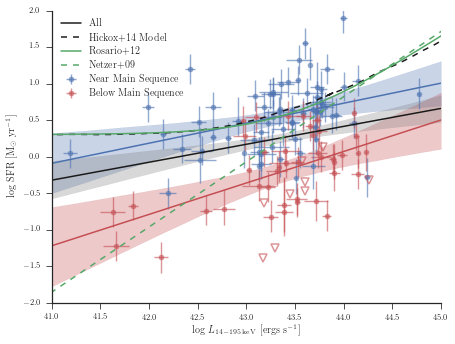

In [16]:
fig = plt.figure(figsize=(textwidth, 3./4.*textwidth))
plt.errorbar(lx_ms, sfr_ms, xerr=lx_err_ms, yerr=bat_c12.loc[(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64), ['sfr_68_up', 'sfr_68_down']].values.transpose(),
             fmt='o', color='b', ls='None', alpha=0.6, label='Near Main Sequence')
plt.errorbar(lx_below2[delta_below2==1], sfr_below2[delta_below2==1], xerr=lx_err_below2[delta_below2==1], yerr=bat_c12.loc[(bat_c12['dlogMS'] < -0.64), ['sfr_68_up', 'sfr_68_down']][delta_below2==1].values.transpose(),
             fmt='o', color='r', ls='None', alpha=0.6, label='Below Main Sequence')
plt.plot(lx_below2[delta_below2==0], sfr_below2[delta_below2==0], marker='v', markeredgecolor='r', markerfacecolor='None',
         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)
plt.plot(xfit, yfit_ms_median, 'b-', lw=1.5)
plt.fill_between(xfit, yfit_ms_lower95, yfit_ms_upper95, color='b', alpha=0.3)
plt.plot(xfit, yfit_below2_median, 'r-', lw=1.5)
plt.fill_between(xfit, yfit_below2_lower95, yfit_below2_upper95, color='r', alpha=0.3)
plt.plot(xfit, yfit_median, 'k-', lw=1.5, label='All')
plt.fill_between(xfit, yfit_lower95, yfit_upper95, color='grey', alpha=0.3)

hickox_model = np.loadtxt('../data/hickox14_lir_v_lagn.csv', delimiter=',')
hickox_sfr = hickox_model[:,1]-np.log10(2.57e43)
hickox_agn = (hickox_model[:,0] + 4.2280)/1.1157

lbol = np.arange(41.5, 46.0, 0.01)
lsf_rosario = np.log10(10**(43.57) + 10**(43.57)*(10**lbol/10**(44.27))**0.78)
lsf_netzer = 41+0.8*(lbol-41)
lbat_model = (lbol+4.2280)/1.1157
c = 0.140904716825
plt.plot(hickox_agn, hickox_sfr, 'k--', lw=1.5, label='Hickox+14 Model')
plt.plot(lbat_model, lsf_rosario-np.log10(2.57e43)+c, 'g-', lw=1.5, label='Rosario+12')
plt.plot(lbat_model, lsf_netzer-np.log10(2.57e43)+c, 'g--', lw=1.5, label='Netzer+09')

plt.xlim(41.0, 45.0)
plt.ylim(-2, 2)
plt.xlabel(r'$\log\,L_{\rm 14-195\,keV}$ [ergs s$^{-1}$]')
plt.ylabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left', fontsize=10)
sn.despine()
fig.savefig(figsave_dir+'sfr_lbat_correlation_split_main_seqeunce.pdf', bbox_inches='tight')

In [42]:
print 'Near MS Sample:'
print 'Slope = ', np.median(lm_ms.chain['beta']), ' +/- ', np.std(lm_ms.chain['beta'])
print 'Intercept = ', np.median(lm_ms.chain['alpha']), ' +/- ', np.std(lm_ms.chain['alpha'])
print 'Sigsqr = ', np.median(lm_ms.chain['sigsqr']), ' +/- ', np.std(lm_ms.chain['sigsqr'])
print 'R^2 = ', np.median(lm_ms.chain['corr']), ' +/- ', np.std(lm_ms.chain['corr'])

Near MS Sample:
Slope =  0.274938651065  +/-  0.0877017082635
Intercept =  -11.3667132312  +/-  3.80093815878
Sigsqr =  0.163943937827  +/-  0.0332050056688
R^2 =  0.382399134901  +/-  0.117924515304


In [43]:
print 'Below MS Sample:'
print 'Slope = ', np.median(lm_below2.chain['beta']), ' +/- ', np.std(lm_below2.chain['beta'])
print 'Intercept = ', np.median(lm_below2.chain['alpha']), ' +/- ', np.std(lm_below2.chain['alpha'])
print 'Sigsqr = ', np.median(lm_below2.chain['sigsqr']), ' +/- ', np.std(lm_below2.chain['sigsqr'])
print 'R^2 = ', np.median(lm_below2.chain['corr']), ' +/- ', np.std(lm_below2.chain['corr'])

Below MS Sample:
Slope =  0.432210042076  +/-  0.110914190916
Intercept =  -18.9311323297  +/-  4.81223633049
Sigsqr =  0.190962233785  +/-  0.0528734223191
R^2 =  0.520525551713  +/-  0.128469204649


In [93]:
bat_c12[((bat_c12['lbat']) < 42.25) & (bat_c12['sfr'] <0.0)]

,mdust,mdust_err_high,mdust_err_low,mdust_flag,tdust,tdust_err_high,tdust_err_low,tdust_flag,alpha,alpha_err_high,...,Redshift,Mstar,sfr,sfr_68_up,sfr_68_down,sfr_err,lbat,lbat_err,lbat_flag,Sy_Type
Name,,,,,,,,,,,,,,,,,,,,,
IC2461,7.093235,0.079094,0.103027,0,19.293414,1.377373,1.005453,0,2.305960,0.291956,...,0.007539,9.470644,-0.496972,0.216717,0.208566,0.083465,42.191278,0.088500,1,Sy 2
NGC1052,6.360464,0.137993,0.162568,0,18.160784,1.714244,1.340894,0,1.569378,0.348421,...,0.005037,10.555279,-1.381072,0.215888,0.215056,0.081288,42.123963,0.070124,1,Sy 2
NGC2655,7.045785,0.415053,0.154401,0,20.612969,1.750476,4.280217,0,1.441451,0.846766,...,0.004670,NaN,-0.374552,0.211705,0.272108,0.184507,41.960680,0.132396,1,Sy 2
NGC3718,7.028733,0.591845,0.084467,0,17.945148,0.543096,4.138958,0,0.328068,1.695533,...,0.003312,10.320196,-0.763807,0.201703,0.211985,0.070269,41.627545,0.127077,1,Sy 2
NGC4138,6.631499,0.032799,0.032718,0,21.526008,0.278430,0.307629,0,0.344721,0.490081,...,0.002962,9.877322,-0.673671,0.200633,0.200798,0.017879,41.836006,0.054829,1,Sy 2
NGC4941,7.382095,0.058916,0.063186,0,14.298952,0.398577,0.363011,0,1.502155,0.291247,...,0.003696,NaN,-0.988066,0.201034,0.201308,0.022910,41.682076,0.106112,1,Sy 2
NGC5273,5.464440,0.071563,0.062150,0,27.202459,0.795725,1.138763,0,1.320437,0.469419,...,0.003549,9.821571,-1.232178,0.202455,0.205964,0.049204,41.657422,0.136035,1,Sy 1
NGC7213,6.916172,0.065857,0.066908,0,20.257244,0.861989,0.820564,0,1.243422,0.337410,...,0.005839,NaN,-0.545396,0.205428,0.205256,0.046912,42.026145,0.048761,1,Sy 2
NGC7465,6.733795,0.042931,0.040659,0,26.533049,0.522478,0.562465,0,1.240628,0.472083,...,0.006565,NaN,-0.024991,0.200942,0.201502,0.024554,42.088780,0.141885,1,LINER


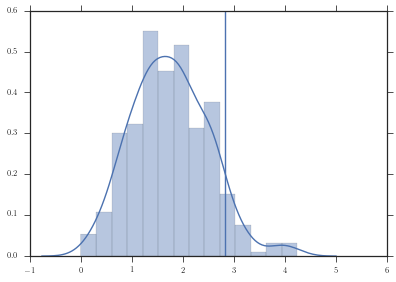

In [26]:
bat_lbol = x*1.1157-4.2280
bat_lsf = y + np.log10(2.57e43)
bat_accretion_rate = bat_lbol - np.log10(0.1) - np.log10(3e10**2) - np.log10(2e33)+np.log10(86400.*365.)
sn.distplot(y-bat_accretion_rate)
plt.axvline(np.log10(1/1.5e-3))

In [27]:
1/10**np.median(y-bat_accretion_rate)

0.017963080001216391